In [2]:
import pandas as pd
from scipy.io import arff
import numpy as np
from sklearn.model_selection import train_test_split

dataarff = arff.loadarff("phpMawTba.arff")
adult_census = pd.DataFrame(dataarff[0])
adult_census[list(adult_census.columns.values)] = adult_census[list(adult_census.columns.values)].applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)
target_name = "class"

target = adult_census[target_name]
data = adult_census.drop(columns=[target_name, "education-num"])
data.head()

C:\Users\samue\AppData\Local\Temp\ipykernel_7060\2706093270.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  adult_census[list(adult_census.columns.values)] = adult_census[list(adult_census.columns.values)].applymap(lambda x: x.decode('utf-8') if isinstance(x, bytes) else x)


,age,workclass,fnlwgt,education,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country
0,25.0,Private,226802.0,11th,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States
1,38.0,Private,89814.0,HS-grad,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States
2,28.0,Local-gov,336951.0,Assoc-acdm,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States
3,44.0,Private,160323.0,Some-college,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688.0,0.0,40.0,United-States
4,18.0,?,103497.0,Some-college,Never-married,?,Own-child,White,Female,0.0,0.0,30.0,United-States


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)

In [4]:
from sklearn.compose import make_column_selector as selector

categorical_columns_selector = selector(dtype_include=object)
categorical_columns = categorical_columns_selector(data)
categorical_columns

['workclass',
 'education',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native-country']

In [5]:
from sklearn.preprocessing import OrdinalEncoder

categorical_preprocessor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1
)

In [6]:
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    [("cat_preprocessor", categorical_preprocessor, categorical_columns)],
    remainder="passthrough"
)

In [7]:
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import Pipeline

model = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", HistGradientBoostingClassifier(random_state=42, max_leaf_nodes=4))
    ]
)
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_preprocessor',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  ['workclass', 'education',
                                                   'marital-status',
                                                   'occupation', 'relationship',
                                                   'race', 'sex',
                                                   'native-country'])])),
                ('classifier',
                 HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                random_state=42))])

In [8]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid = {
    "classifier__learning_rate": (0.01, 0.1, 1, 10),
    "classifier__max_leaf_nodes": (3, 10, 30),
}
model_grid_search = GridSearchCV(model, param_grid, n_jobs=2, cv=2)
model_grid_search.fit(X_train, y_train)

CPU times: total: 6.42 s
Wall time: 5.15 s


c:\env\py310\lib\site-packages\sklearn\compose\_column_transformer.py:1624: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_preprocessor',
                                                                         OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                        unknown_value=-1),
                                                                         ['workclass',
                                                                          'education',
                                                                          'marital-status',
                                                                          'occupation',
                                                                          'relationship',
                                                                          'race',
                                                                          'sex',
                                                                          'native-country'])])),
                                       ('classifier',
                                        HistGradientBoostingClassifier(max_leaf_nodes=4,
                                                                       random_state=42))]),
             n_jobs=2,
             param_grid={'classifier__learning_rate': (0.01, 0.1, 1, 10),
                         'classifier__max_leaf_nodes': (3, 10, 30)})

In [9]:
accuracy = model_grid_search.score(X_test, y_test)
print(
    f"The test accuracy score of the grid-searcher pipeline is: {accuracy:.2f}"
)

The test accuracy score of the grid-searcher pipeline is: 0.88


In [10]:
model_grid_search.predict(X_test.iloc[0:5])
print(f"The best set of parameters is: {model_grid_search.best_params_}")

The best set of parameters is: {'classifier__learning_rate': 0.1, 'classifier__max_leaf_nodes': 30}


In [11]:
cv_results = pd.DataFrame(model_grid_search.cv_results_).sort_values(
    "mean_test_score", ascending=False
)

cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__learning_rate,param_classifier__max_leaf_nodes,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
5,0.350345,0.018107,0.076011,0.002501,0.1,30,"{'classifier__learning_rate': 0.1, 'classifier...",0.867766,0.867649,0.867708,0.000058,1
4,0.266739,0.003500,0.072360,0.000851,0.1,10,"{'classifier__learning_rate': 0.1, 'classifier...",0.866729,0.866557,0.866643,0.000086,2
6,0.129598,0.002087,0.056844,0.001670,1.0,3,"{'classifier__learning_rate': 1, 'classifier__...",0.860559,0.861261,0.860910,0.000351,3
7,0.108510,0.003000,0.056752,0.002753,1.0,10,"{'classifier__learning_rate': 1, 'classifier__...",0.857993,0.861862,0.859927,0.001934,4
3,0.221120,0.004896,0.068511,0.003001,0.1,3,"{'classifier__learning_rate': 0.1, 'classifier...",0.852752,0.854272,0.853512,0.000760,5


In [12]:
cv_results.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12 entries, 5 to 9
Data columns (total 12 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   mean_fit_time                     12 non-null     float64
 1   std_fit_time                      12 non-null     float64
 2   mean_score_time                   12 non-null     float64
 3   std_score_time                    12 non-null     float64
 4   param_classifier__learning_rate   12 non-null     float64
 5   param_classifier__max_leaf_nodes  12 non-null     int32  
 6   params                            12 non-null     object 
 7   split0_test_score                 12 non-null     float64
 8   split1_test_score                 12 non-null     float64
 9   mean_test_score                   12 non-null     float64
 10  std_test_score                    12 non-null     float64
 11  rank_test_score                   12 non-null     int32  
dtypes: float64(9), i

In [13]:
column_results = [f"param_{name}" for name in param_grid.keys()]
column_results += ["mean_test_score", "std_test_score", "rank_test_score"]
cv_results = cv_results[column_results]

In [14]:
def shorten_param(param_name):
    if "__" in param_name:
        return param_name.rsplit("__", 1)[1]
    return param_name

cv_results = cv_results.rename(shorten_param, axis=1)
cv_results

,learning_rate,max_leaf_nodes,mean_test_score,std_test_score,rank_test_score
5,0.10,30,0.867708,0.000058,1
4,0.10,10,0.866643,0.000086,2
6,1.00,3,0.860910,0.000351,3
7,1.00,10,0.859927,0.001934,4
3,0.10,3,0.853512,0.000760,5
8,1.00,30,0.851547,0.001798,6
2,0.01,30,0.845541,0.002289,7
1,0.01,10,0.817832,0.001124,8
0,0.01,3,0.797166,0.000715,9
10,10.00,10,0.618080,0.124277,10


In [15]:
pivoted_cv_results = cv_results.pivot_table(
    values="mean_test_score",
    index=["learning_rate"],
    columns=["max_leaf_nodes"],
)

pivoted_cv_results

max_leaf_nodes,3,10,30
learning_rate,,,
0.01,0.797166,0.817832,0.845541
0.10,0.853512,0.866643,0.867708
1.00,0.860910,0.859927,0.851547
10.00,0.283476,0.618080,0.351642


<bound method _AxesBase.invert_yaxis of <Axes: xlabel='max_leaf_nodes', ylabel='learning_rate'>>

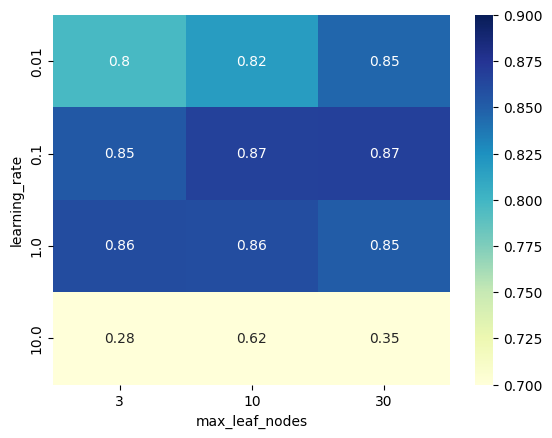

In [16]:
import seaborn as sns

ax = sns.heatmap(
    pivoted_cv_results, annot=True, cmap="YlGnBu", vmin=0.7, vmax=0.9
)
ax.invert_yaxis